# MNIST LSTM Classifier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data.dataloader as dataloader

from tqdm.notebook import trange, tqdm

In [2]:
# The size of our mini batches
batch_size = 128
# How many itterations of our dataset
num_epochs = 50
# Optimizer learning rate
learning_rate = 1e-4
# Where to load/save the dataset from 
data_set_root = "../../datasets"

In [3]:
device = torch.device(0 if torch.cuda.is_available() else 'cpu')

### Create MNIST Dataset and Dataloader

In [4]:
# Prepare a composition of transforms
# transforms.Compose will perform the transforms in order
# NOTE: some transform only take in a PIL image, others only a Tensor
# EG Resize and ToTensor take in a PIL Image, Normalize takes in a Tensor
# Refer to documentation
transform = transforms.Compose([
            transforms.Resize(32),
            transforms.ToTensor(),
            transforms.Normalize([0.1307], [0.308])])

# Note: ToTensor() will scale unit8 and similar type data to a float and re-scale to 0-1
# Note: We are normalizing with the dataset mean and std 

In [5]:
# Define our MNIST Datasets
# Can also try with CIFAR10 Dataset
# https://pytorch.org/docs/stable/torchvision/datasets.html#mnist
train_data = datasets.MNIST(data_set_root, train=True, download=True, transform=transform)
test_data = datasets.MNIST(data_set_root, train=False, download=True, transform=transform)

# We are going to split the test dataset into a train and validation set 90%/10%
validation_split = 0.9

# Determine the number of samples for each split
n_train_examples = int(len(train_data) * validation_split)
n_valid_examples = len(train_data) - n_train_examples

# The function random_split will take our dataset and split it randomly and give us dataset
# that are the sizes we gave it
# Note: we can split it into to more then two pieces!
train_data, valid_data = torch.utils.data.random_split(train_data, [n_train_examples, n_valid_examples],
                                                       generator=torch.Generator().manual_seed(42))

# IMPORTANT TO KNOW!!!!!!!!!
# Here we pass the random_split function a manual seed, this is very important as if we did not do this then 
# everytime we randomly split our training and validation set we would get different splits!!!
# For example if we saved our model and reloaded it in the future to train some more, the dataset that we now use to
# train with will undoubtably contain datapoints that WERE in the validation set initially!!
# Our model would therefore be trained with both validation and training data -- very bad!!!
# Setting the manual seed to the same value everytime prevents this!

In [6]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


In [7]:
# Create the training, Validation and Evaluation/Test Datasets
# It is best practice to separate your data into these three Datasets
# Though depending on your task you may only need Training + Evaluation/Test or maybe only a Training set
# (It also depends on how much data you have)
# https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataloader
train_loader = dataloader.DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = dataloader.DataLoader(valid_data, batch_size=batch_size)
test_loader  = dataloader.DataLoader(test_data, batch_size=batch_size)

### Create Image Patch LSTM

In [8]:
# Define our network class by using the nn.module
class ResBlockMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(ResBlockMLP, self).__init__()
        self.norm1 = nn.LayerNorm(input_size)
        self.fc1 = nn.Linear(input_size, input_size//2)
        
        self.norm2 = nn.LayerNorm(input_size//2)
        self.fc2 = nn.Linear(input_size//2, output_size)
        
        self.fc3 = nn.Linear(input_size, output_size)

        self.act = nn.ELU()

    def forward(self, x):
        x = self.act(self.norm1(x))
        skip = self.fc3(x)
        
        x = self.act(self.norm2(self.fc1(x)))
        x = self.fc2(x)
        
        return x + skip


class RNN(nn.Module):
    def __init__(self, output_size=10, patch_size=4, lstm_layers=1, hidden_size=64, num_blocks=1):
        super(RNN, self).__init__()
        
        self.unshuffle = nn.PixelUnshuffle(downscale_factor=patch_size)
        
        self.fc_in = nn.Linear(patch_size**2, hidden_size)
        
        self.lstm = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, 
                            num_layers=lstm_layers, batch_first=True)
              
        blocks = [ResBlockMLP(hidden_size, hidden_size) for _ in range(num_blocks)]
        self.res_blocks = nn.Sequential(*blocks)
        
        self.fc_out = nn.Linear(hidden_size, output_size)
        self.act = nn.ELU()


    def forward(self, input_data, hidden_in, mem_in):
        input_seq = self.unshuffle(input_data)

        bs, c, h, w = input_seq.shape
        input_seq = input_seq.reshape(bs, c, h*w).transpose(1, 2)  # BSxLxC

        x = self.act(self.fc_in(input_seq))
        
        output, (hidden_out, mem_out) = self.lstm(x, (hidden_in, mem_in))

        x  = self.act(self.res_blocks(output))
        
        return self.fc_out(x), hidden_out, mem_out

In [9]:
# Create model
lstm_layers = 3
hidden_size = 64
patch_size = 2

weather_rnn = RNN(output_size=10, patch_size=patch_size, 
                  lstm_layers=lstm_layers, hidden_size=hidden_size).to(device)

# Initialize the optimizer with above parameters
optimizer = optim.Adam(weather_rnn.parameters(), lr=learning_rate)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()  # mean squared error

In [10]:
# Let's see how many Parameters our Model has!
num_model_params = 0
for param in weather_rnn.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 109354 (Approximately 0 Million) Parameters!


In [11]:
training_loss_logger = []
training_acc_logger = []

valid_loss_logger = []
valid_acc_logger = []

In [12]:
train_acc = 0
valid_acc = 0

pbar = trange(0, num_epochs, leave=False, desc="Epoch")    
for epoch in pbar:
    pbar.set_postfix_str('Accuracy: Train %.2f%%, Val %.2f%%' % (train_acc * 100, valid_acc * 100))

    weather_rnn.train()
    train_acc = 0
    for data, label in tqdm(train_loader, desc="Training", leave=False):
        data = data.to(device)
        label = label.to(device)
        
        hidden = torch.zeros(lstm_layers, data.shape[0], hidden_size, device=device)
        memory = torch.zeros(lstm_layers, data.shape[0], hidden_size, device=device)

        data_pred, hidden, memory = weather_rnn(data, hidden, memory)
        last_target = data_pred[:, -1, :]

        loss = loss_fn(last_target, label)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        training_loss_logger.append(loss.item())
        train_acc += (last_target.argmax(1) == label).sum()
        
    train_acc = (train_acc/len(train_data)).item()
    training_acc_logger.append(train_acc)
        
    weather_rnn.eval()
    valid_acc = 0
    with torch.no_grad():
        for data, label in tqdm(valid_loader, desc="Validation", leave=False):
            data = data.to(device)
            label = label.to(device)

            hidden = torch.zeros(lstm_layers, data.shape[0], hidden_size, device=device)
            memory = torch.zeros(lstm_layers, data.shape[0], hidden_size, device=device)

            data_pred, hidden, memory = weather_rnn(data, hidden, memory)
            last_target = data_pred[:, -1, :]

            loss = loss_fn(last_target, label)
            
            valid_loss_logger.append(loss.item())
            valid_acc += (last_target.argmax(1) == label).sum()
            
    valid_acc = (valid_acc/len(valid_data)).item()
    valid_acc_logger.append(valid_acc)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

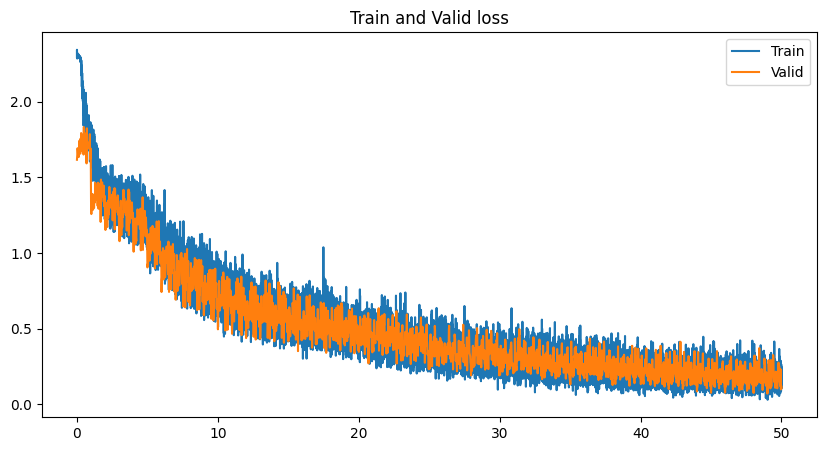

In [13]:
_ = plt.figure(figsize=(10, 5))
_ = plt.title("Train and Valid loss")
_ = plt.plot(np.linspace(0, num_epochs, len(training_loss_logger)), training_loss_logger)
_ = plt.plot(np.linspace(0, num_epochs, len(valid_loss_logger)), valid_loss_logger)

_ = plt.legend(["Train", "Valid"])

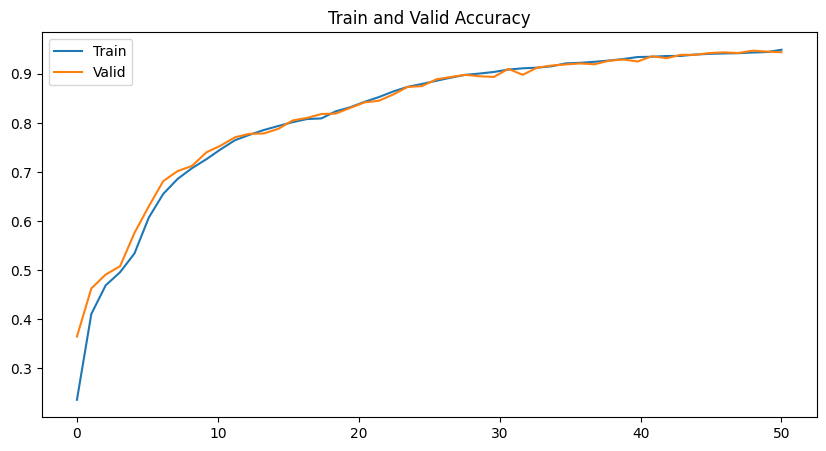

In [14]:
_ = plt.figure(figsize=(10, 5))
_ = plt.title("Train and Valid Accuracy")
_ = plt.plot(np.linspace(0, num_epochs, len(training_acc_logger)), training_acc_logger)
_ = plt.plot(np.linspace(0, num_epochs, len(valid_acc_logger)), valid_acc_logger)

_ = plt.legend(["Train", "Valid"])

In [15]:
weather_rnn.eval()
test_acc = 0
with torch.no_grad():
    for data, label in tqdm(test_loader, desc="Testing", leave=False):
        data = data.to(device)
        label = label.to(device)

        hidden = torch.zeros(lstm_layers, data.shape[0], hidden_size, device=device)
        memory = torch.zeros(lstm_layers, data.shape[0], hidden_size, device=device)

        data_pred, hidden, memory = weather_rnn(data, hidden, memory)
        last_target = data_pred[:, -1, :]

        test_acc += (last_target.argmax(1) == label).sum()
test_acc = (test_acc/len(test_data)).item()

print("Test Accuracy %.2f%%" % (test_acc * 100))

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy 94.75%
